## Sentiment Classification of Tweets Using BiGRU

In [1]:
import numpy as np
import csv
import torch
import torch.nn as nn
import torchtext
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

### **Dataset Preparation and Preprocessing**

In [3]:
# read the data
def read_data():
    return csv.reader(open("./training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))
    
# print the head (i.e., the first 5 rows) of the dataset
for i, row in enumerate(read_data()):
    print(row)
    if i >= 5:
        break

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467810917', 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY', 'mattycus', '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']
['0', '1467811184', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'ElleCTF', 'my whole body feels itchy and like its on fire ']
['0', '1467811193', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'Karoli', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
['0', '1467811372', 'Mon Apr 06 22:20:00 PDT 2009', 'NO_QUERY', 'joy_wolf', '@Kwesidei not the whole crew ']


In [4]:
# Convert the text into lowercase characters and split it
def split_text(text):
    text = text.replace(".", " . ").replace("?", " ? ").replace(",", " , ").replace(";", " ; ")
    return text.lower().split()

In [5]:
# get the indices of individual words for each tweet using GloVe
glove = torchtext.vocab.GloVe(name="6B", dim=50)
import random
lst = list()
for i, row in enumerate(read_data()):
    if i % 5 == 0:
        text = row[-1]
        indices = [glove.stoi[w] for w in split_text(text) if w in glove.stoi]
        if not indices:
            continue
        indices = torch.tensor(indices)  # store the indices of words for each tweet in a PyTorch tensor
        label = [0 if row[0]=="0" else 1 if row[0]=="4" else 2]
        label = torch.tensor(label[-1])  # store the label of each tweet in a PyTorch tensor
        lst.append((indices, label))

In [6]:
# randomly split the dataset into train, validation and test sets
random.seed(20)
random.shuffle(lst)
train_set = lst[:round(len(lst)*0.6)]
valid_set = lst[round(len(lst)*0.6):round(len(lst)*0.8)]
test_set = lst[round(len(lst)*0.8):]

# an example from the train set
tweet, label = train_set[23]
print('Tweet:\n', tweet)
print('Label:\n', label)

Tweet:
 tensor([   41,   733,    41,   405,    60,    22, 78188,    41,    86,   588,
          169,   180,     4,    37,  6844,    22,   364,  3496,     1, 73048,
            2,   595,     4,    30,    56,   117,     0])
Label:
 tensor(1)


### **Building Bidirectional GRU Model**

In [7]:
# build the BiGRU model
class TweetBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetBiGRU, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.encoder = nn.GRU(input_size, hidden_size, batch_first=True, 
                              bidirectional=True)
        self.predictor = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.encoder(embedded)
        output = self.predictor(output[:, -1, :])
        return output

model = TweetBiGRU(50, 100, 3)

In [8]:
# batch tweets together
class TweetBatcher:
    def __init__(self, tweets, batch_size=64, drop_last=False):
        self.tweets_by_length = {}
        for words, label in tweets:
            wlen = words.shape[0]
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last)
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): 
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

### **Training the Model**

In [9]:
def evaluate_acc(model, data):
    correct, total = 0, 0
    for tweets, labels in data:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [10]:
def train_BiGRU(model, train_sdata, valid_data, num_epochs=10, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, val_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train_data:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(evaluate_acc(model, train_data))
        val_acc.append(evaluate_acc(model, valid_data))
        print("Epoch %d:\n\tLoss %f; Train Accuracy %f; Validation Accuracy %f" % 
              (epoch+1, loss, train_acc[-1], val_acc[-1]))

    # plot the training curve
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.title("Training Curve")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.xticks(np.arange(0, 15, 1))
    plt.show()

Epoch 1:
	Loss 0.660328; Train Accuracy 0.617417; Validation Accuracy 0.617276
Epoch 2:
	Loss 0.635153; Train Accuracy 0.675922; Validation Accuracy 0.671618
Epoch 3:
	Loss 0.553600; Train Accuracy 0.684682; Validation Accuracy 0.682371
Epoch 4:
	Loss 0.620217; Train Accuracy 0.692107; Validation Accuracy 0.687464
Epoch 5:
	Loss 0.547909; Train Accuracy 0.696898; Validation Accuracy 0.692101
Epoch 6:
	Loss 0.543435; Train Accuracy 0.697964; Validation Accuracy 0.694113
Epoch 7:
	Loss 0.623028; Train Accuracy 0.703352; Validation Accuracy 0.698562
Epoch 8:
	Loss 0.600593; Train Accuracy 0.705816; Validation Accuracy 0.701360
Epoch 9:
	Loss 0.516524; Train Accuracy 0.708629; Validation Accuracy 0.704551
Epoch 10:
	Loss 0.468757; Train Accuracy 0.710882; Validation Accuracy 0.705793
Epoch 11:
	Loss 0.508517; Train Accuracy 0.712718; Validation Accuracy 0.707805
Epoch 12:
	Loss 0.505252; Train Accuracy 0.712455; Validation Accuracy 0.707993
Epoch 13:
	Loss 0.477523; Train Accuracy 0.716866

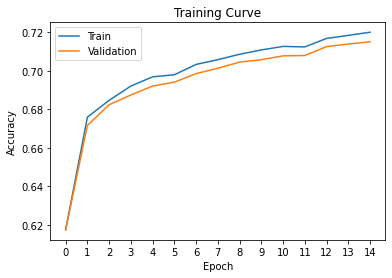

In [11]:
# train the model
train_data = TweetBatcher(train_set, batch_size=64, drop_last=True)
valid_data = TweetBatcher(valid_set, batch_size=64, drop_last=False)
train_BiGRU(model, train_data, valid_data, num_epochs=15, learning_rate=2e-5)

### **Evaluation**

In [13]:
# get the accuracy on the test set
test_data = TweetBatcher(test_set, batch_size=64, drop_last=False)
test_acc = evaluate_acc(model, test_data)
print('Test Accuracy:', test_acc)

Test Accuracy: 0.7156061368209256
